In [1]:
import jax
import numpyro
import blackjax
import numpy as np
import jax.numpy as jnp
import numpyro.distributions as dist
from numpyro.infer.util import initialize_model
from numpyro.infer.reparam import TransformReparam
import matplotlib.pyplot as plt

/Users/madhav/anaconda3/envs/experiment/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def eight_schools(J, sigma, y=None):
    mu = numpyro.sample('mu', dist.Normal(2, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    with numpyro.plate('J', J):
        theta = numpyro.sample('theta', dist.Normal(mu, tau))
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [3]:
# Model initialization values
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [4]:
rng_key = jax.random.PRNGKey(0)
init_params, potential_fn_gen, *_ = initialize_model(
    rng_key,
    eight_schools,
    model_args=(J, sigma, y),
    dynamic_args=True,
)

In [5]:
logdensity_fn = lambda position: -potential_fn_gen(J, sigma, y)(position)
initial_position = init_params.z

In [6]:
num_warmup = 150

adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, target_acceptance_rate=0.8
)
(last_state, parameters), intermediate_states = adapt.run(rng_key, initial_position, num_warmup)

[0.61400837 0.6213116  0.65483063 0.00762925 0.09342316 0.51231676
 0.01197798 0.02590327]


In [7]:
kernel = blackjax.nuts(logdensity_fn, **parameters).step

In [8]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    extra, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )

In [9]:
num_sample = 1000

states, infos = inference_loop(rng_key, kernel, last_state, num_sample)
_ = states.position["mu"].block_until_ready()

In [10]:
states[0]

{'mu': Array([ 6.891893  ,  9.259047  ,  1.9493519 ,  2.944696  ,  1.9701923 ,
         3.0259478 ,  8.112939  ,  4.240861  ,  5.202689  ,  4.7177057 ,
         5.070146  ,  5.6988683 ,  3.9592292 ,  3.7467306 , -1.2290316 ,
        -1.0576295 ,  0.50259733,  6.9113383 ,  4.6882095 ,  3.4751701 ,
         5.5258703 ,  4.9236183 ,  7.392249  ,  8.185166  ,  6.2429605 ,
         5.769285  ,  5.2990117 ,  7.8028784 ,  9.464898  ,  7.4758635 ,
         7.596323  ,  7.687726  ,  8.91956   ,  9.030388  ,  1.3131826 ,
         6.62939   ,  6.58357   ,  4.482095  ,  1.8501284 ,  3.2900736 ,
        13.413973  ,  2.842345  ,  4.6230583 ,  7.8119726 ,  3.683801  ,
         2.8606431 ,  4.4328337 ,  4.1115575 ,  5.7414937 , -3.9768686 ,
        -0.80416524, -1.8459518 , -0.36022076,  2.1947892 ,  2.0483997 ,
         7.614108  ,  5.699104  ,  2.6811397 ,  4.268973  ,  5.7326093 ,
         3.3640294 ,  8.032785  ,  8.130287  ,  7.8298984 , -0.08371621,
         6.2265887 ,  6.2265887 ,  6.2265887 

In [11]:
def scatterplt(samples):
    fig, axes = plt.subplots(4, 2, figsize=(10, 12))
    axes = axes.flatten()
    # reparam_sample, mvn, mu_theta, std_theta = reparameterize_samples_dist(samples, best_c)
    # reparam_sample = reparam_sample if reparam else samples['theta'].T
    samples_theta = samples['theta'].T
    for i in range(8):
        axes[i].scatter(samples_theta[i], samples['tau'])
        axes[i].set_xlabel(f'theta_{i}')
        axes[i].set_ylabel('log_std')

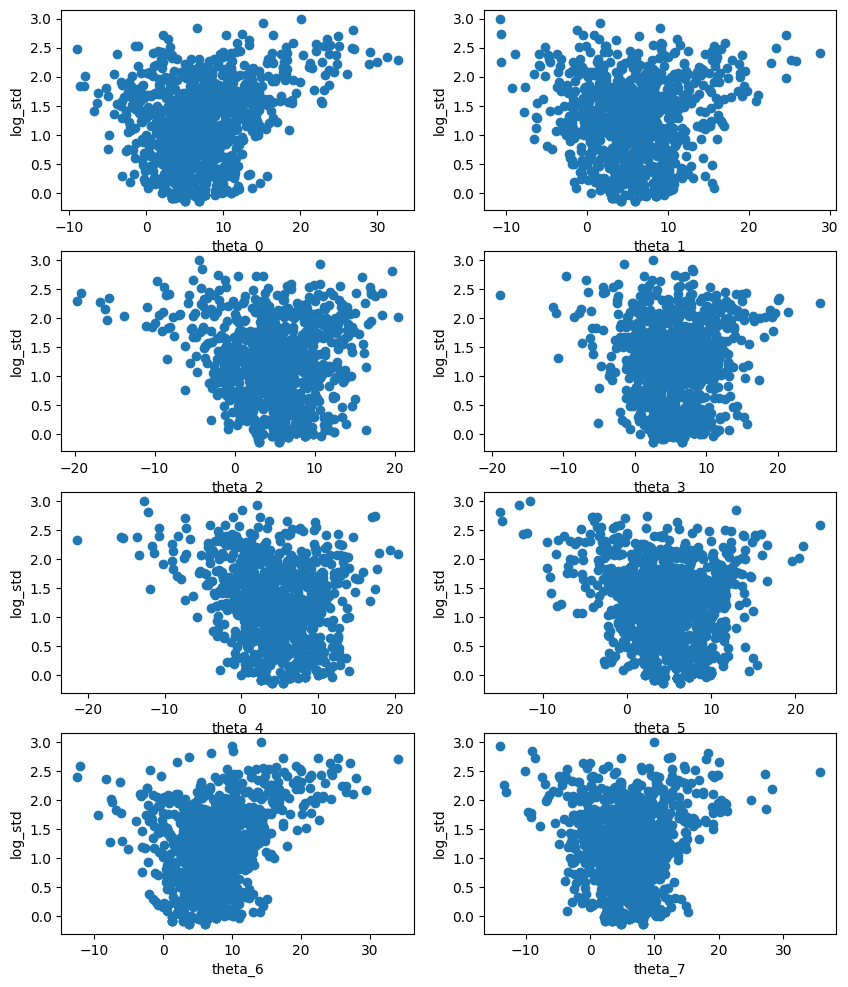

In [12]:
scatterplt(states[0])

In [13]:
acceptance_rate = np.mean(infos[0])
num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

\Average acceptance rate: 0.83
There were 0.70% divergent transitions
